In [1]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2025-03-18 15:11:39.988384: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-18 15:11:39.988446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.4.1
1.21.6
4.6.1
3.1.0


## 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [6]:
import datasets
from datasets import load_dataset

nsmc_dataset = load_dataset('e9t/nsmc')
print(nsmc_dataset)

README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

nsmc.py:   0%|          | 0.00/3.18k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [7]:
train = nsmc_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [8]:
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




## 2. klue/bert-base model 및 tokenizer 불러오기

In [9]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/transformers/modeling_utils.py:1205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

## 3. 위에서 불러온 tokenizer로 데이터셋 전처리, model 학습 진행

### tokenizer 전처리

In [10]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

In [ ]:
# map : 데이터셋을 한번에 토크나이징할 때 사용하는 기법
# Data dictionary에 있는 모든 데이터들을 빠르게 적용
# map을 사용해 토크나이징을 진행할 때 batch 적용 -> batched=True

hf_dataset = nsmc_dataset.map(transform, batched=True)

# train & test split
hf_train_dataset = hf_dataset['train']
hf_test_dataset = hf_dataset['test']

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [16]:
# train & validation split

split_dataset = hf_train_dataset.train_test_split(test_size=0.2)

hf_train_dataset = split_dataset['train']
hf_val_dataset = split_dataset['test']

---

### bucketing 용 전처리

In [ ]:
def transform_bucket(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = False,   # 여기 바꿔줘야 됨
        return_token_type_ids = False,
        )

In [29]:
# map : 데이터셋을 한번에 토크나이징할 때 사용하는 기법
# Data dictionary에 있는 모든 데이터들을 빠르게 적용
# map을 사용해 토크나이징을 진행할 때 batch 적용 -> batched=True

buc_dataset = nsmc_dataset.map(transform_bucket, batched=True)

# train & test split
buc_train_dataset = buc_dataset['train']
buc_test_dataset = buc_dataset['test']

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [30]:
# train & validation split

split_dataset = buc_train_dataset.train_test_split(test_size=0.2)

buc_train_dataset = split_dataset['train']
buc_val_dataset = split_dataset['test']

---

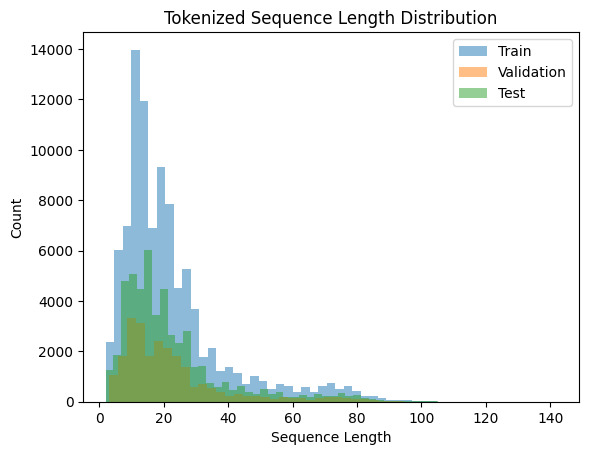

Train 95% length: 62.0
Validation 95% length: 63.0
Test 95% length: 62.0


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 attention_mask의 길이 확인
train_lengths = [sum(example['attention_mask']) for example in hf_train_dataset]
val_lengths = [sum(example['attention_mask']) for example in hf_val_dataset]
test_lengths = [sum(example['attention_mask']) for example in hf_test_dataset]

# 히스토그램 그리기
plt.hist(train_lengths, bins=50, alpha=0.5, label='Train')
plt.hist(val_lengths, bins=50, alpha=0.5, label='Validation')
plt.hist(test_lengths, bins=50, alpha=0.5, label='Test')
plt.legend()
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Tokenized Sequence Length Distribution')
plt.show()

# 95% 구간 계산
train_95 = np.percentile(train_lengths, 95)
val_95 = np.percentile(val_lengths, 95)
test_95 = np.percentile(test_lengths, 95)

print(f"Train 95% length: {train_95}")
print(f"Validation 95% length: {val_95}")
print(f"Test 95% length: {test_95}")


### max_length = 62 로 다시 토큰화

In [19]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        max_length=62,
        return_token_type_ids = False,
        )

In [20]:
# map : 데이터셋을 한번에 토크나이징할 때 사용하는 기법
# Data dictionary에 있는 모든 데이터들을 빠르게 적용
# map을 사용해 토크나이징을 진행할 때 batch 적용 -> batched=True

hf_dataset = nsmc_dataset.map(transform, batched=True)

# train & test split
hf_train_dataset = hf_dataset['train']
hf_test_dataset = hf_dataset['test']

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [21]:
# train & validation split

split_dataset = hf_train_dataset.train_test_split(test_size=0.2)

hf_train_dataset = split_dataset['train']
hf_val_dataset = split_dataset['test']

### model 학습

In [22]:
# Trainer를 사용하기 위해서 TrainingArguments를 통해 학습 관련 설정을 미리 지정

import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = '/home/downtown/aiffel/HuggingFace/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 16,   # 각 device 당 batch size, 8->16
    per_device_eval_batch_size = 16,    # evaluation 시에 batch size, 8->16
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [23]:
from evaluate import load
import numpy as np

# accuracy metric 불러오기
metric = load('accuracy')

# compute_metrics 함수
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

### 1차 실험 : max_length : 62, batch_size : 16

In [24]:
# trainer에 model, arguments, train_dataset, eval_dataset, compute_metrics를 넣고 train 진행

trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.240000,0.238950,0.908533
2,0.182600,0.281342,0.909033
3,0.104000,0.392804,0.908833


TrainOutput(global_step=22500, training_loss=0.1827078657362196, metrics={'train_runtime': 11887.662, 'train_samples_per_second': 1.893, 'total_flos': 0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 16384, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -17100800, 'train_mem_gpu_alloc_delta': 427679232, 'train_mem_cpu_peaked_delta': 165830656, 'train_mem_gpu_peaked_delta': 723597824})

In [25]:
trainer.evaluate(hf_test_dataset)

{'eval_loss': 0.42379823327064514,
 'eval_accuracy': 0.90276,
 'eval_runtime': 297.9238,
 'eval_samples_per_second': 167.828,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 20230144,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 352256,
 'eval_mem_gpu_peaked_delta': 35529728}

생각보다 바로 acc가 90이 넘었다.    
좀 더 높여보는 시도를 해야겠다.  

### 1차 실험 모델 구조 확인

In [26]:
from transformers import AutoModelForSequenceClassification, AutoConfig

# 체크포인트 경로
checkpoint_path = "/home/downtown/aiffel/HuggingFace/transformers/checkpoint-22500"

# Config 불러오기
config = AutoConfig.from_pretrained(checkpoint_path)
print("모델 Config:")
print(config)

# 모델 불러오기
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
print("\n모델 구조:")
print(model)


모델 Config:
BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/transformers/modeling_utils.py:1205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load


모델 구조:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

### 2차 실험 : Unfreeze 실험 - 0, 4, 6, 8

In [27]:
from transformers import AutoModelForSequenceClassification, Trainer
import torch

# 체크포인트 경로
checkpoint_path = "/home/downtown/aiffel/HuggingFace/transformers/checkpoint-22500"

# 실험할 레이어 수
unfreeze_options = [0, 4, 6, 8]  # 전부 프리징, 마지막 4,6,8개 언프리징

for unfreeze_count in unfreeze_options:
    print(f"\n==== 실험: 마지막 {unfreeze_count}개 레이어 언프리징 ====")

    # 모델 불러오기
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

    # 모든 파라미터 프리징
    for param in model.bert.parameters():
        param.requires_grad = False

    # 일부 레이어 언프리징
    if unfreeze_count > 0:
        for layer in model.bert.encoder.layer[-unfreeze_count:]:
            for param in layer.parameters():
                param.requires_grad = True

    # classifier는 항상 학습
    for param in model.classifier.parameters():
        param.requires_grad = True

    # 확인용: 학습 가능한 파라미터 수 출력
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params}")

    # Trainer 재정의
    trainer = Trainer(
        model=model,
        args=training_arguments,  # 기존 설정 사용
        train_dataset=hf_train_dataset,
        eval_dataset=hf_val_dataset,
        compute_metrics=compute_metrics,
    )

    # 학습
    trainer.train()

    # 모델 저장 (선택적)
    model.save_pretrained(f"./saved_models/bert_unfreeze_{unfreeze_count}")
    print(f"저장 완료: ./saved_models/bert_unfreeze_{unfreeze_count}")



==== 실험: 마지막 0개 레이어 언프리징 ====
Trainable parameters: 1538


Epoch,Training Loss,Validation Loss,Accuracy
1,0.048700,0.374536,0.908900
2,0.051200,0.381761,0.908833
3,0.089400,0.384489,0.908833


저장 완료: ./saved_models/bert_unfreeze_0

==== 실험: 마지막 4개 레이어 언프리징 ====


/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/transformers/modeling_utils.py:1205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

Trainable parameters: 28353026


Epoch,Training Loss,Validation Loss,Accuracy
1,0.054500,0.446508,0.906033
2,0.049200,0.496572,0.906000
3,0.087900,0.525829,0.906167


저장 완료: ./saved_models/bert_unfreeze_4

==== 실험: 마지막 6개 레이어 언프리징 ====


/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/transformers/modeling_utils.py:1205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

Trainable parameters: 42528770


Epoch,Training Loss,Validation Loss,Accuracy
1,0.041000,0.659602,0.903467
2,0.035900,0.704237,0.903967
3,0.092200,0.683686,0.906233


저장 완료: ./saved_models/bert_unfreeze_6

==== 실험: 마지막 8개 레이어 언프리징 ====


/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/transformers/modeling_utils.py:1205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

Trainable parameters: 56704514


Epoch,Training Loss,Validation Loss,Accuracy
1,0.032400,0.698775,0.902467
2,0.029900,0.731797,0.902467
3,0.098100,0.717394,0.905300


저장 완료: ./saved_models/bert_unfreeze_8


실험 결과를 보면 전부다 freeze 했을 떄가 제일 Acc가 높았다.   
그렇다고 눈에 띄게 높은 건 또 아니라서 큰 의미는 없는 것 같다.   
언프리징을 할 수록 정확도가 떨어지는 것도 신기하다.   
과적합되는 건가..

### bucketing task

In [32]:
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

data_collator = DataCollatorWithPadding(tokenizer=huggingface_tokenizer, padding='longest')

In [33]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    group_by_length=True,   # Bucketing 적용!
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
)

In [38]:
trainer = Trainer(
    model=huggingface_model,
    args=training_args,
    train_dataset=buc_train_dataset,
    eval_dataset=buc_val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.170800,0.286923,0.902400
2,0.098700,0.371958,0.902833
3,0.051800,0.471559,0.907367


TrainOutput(global_step=11250, training_loss=0.10813317150539822, metrics={'train_runtime': 6896.1967, 'train_samples_per_second': 1.631, 'total_flos': 123057754043136.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -20140032, 'train_mem_gpu_alloc_delta': 909072384, 'train_mem_cpu_peaked_delta': 135249920, 'train_mem_gpu_peaked_delta': 3762892800})

In [39]:
trainer.evaluate(buc_test_dataset)

{'eval_loss': 0.5084637999534607,
 'eval_accuracy': 0.90068,
 'eval_runtime': 200.657,
 'eval_samples_per_second': 249.181,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 9359360,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 132281856}

## 회고
처음에 로컬에서 베이스라인을 돌리는데 너무 오래 걸려서 (약 16시간....?)  
lms에서 따로 돌렸는데 (약 13시간 예상) 중간에 커널이 끊기면서 결국 베이스라인 성능을 확인하지 못 한 점이 아쉽다.  
그래도 운이 좋게 truncation과 batch size만 조정했을 뿐인데 바로 성능이 90이 넘어서 다행이었다.  
그 성능을 바탕으로 unfreeze 실험을 수행해봤는데 생각보다 unfreeze를 하면 할 수록 성능이 떨어지는 모습을 확인했다.  
동일한 데이터로 다시 학습을 해서 그런 것 같기도 하다.  
다음에는 다른 데이터로 파인튜닝 했을 때 결과를 확인해보고 싶다.  
bucketing도 수행해봤는데 성능에 큰 차이는 없는데 시간은 1시간 정도 단축이 되어서 적용할만한 옵션이라고 생각한다.  
또, 에폭을 거칠수록 정확도가 상승하는 모습을 볼 수 있는데 에폭을 더 크게 줬을 때 어디까지 올라가는 지도 추가로 궁금해졌다.   